In [1]:

import torch
import json
import os
import numpy as np
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
from pdf2image import convert_from_path
import tempfile
from pytesseract import Output
import cv2
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_trf
import tensorflow as tf
import pandas as pd
from subprocess import call
import subprocess
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torch.utils.data import DataLoader, Dataset
import uuid
import gc
from tqdm import tqdm
from tqdm import trange
from time import sleep
import adabound

nlp = spacy.load("en_core_web_trf")


def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent


In [2]:


torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 5)
model.to(device)
model.load_state_dict(torch.load('./model_sgd_resnet50_pretrained.pt'))
model.eval()




FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [3]:
torch.cuda.empty_cache()
test_img = cv2.imread("noisy_documents_dataset/testing_data/images/87093315_87093318.png" , cv2.IMREAD_COLOR)
test_img = cv2.cvtColor(test_img , cv2.COLOR_BGR2RGB).astype(np.float32)
test_img /= 255.0
test_img = torchvision.transforms.ToTensor()(test_img)
test_img.to(device)
test_img = test_img.unsqueeze(1).to(device)
print(test_img.shape)
output = model(test_img)
boxes = output[0]['boxes'].data.cpu().numpy()
test_img = test_img[0].permute(1 , 2 , 0).cpu().numpy()
print(boxes , len(boxes))

torch.Size([3, 1, 1000, 767])
[[1.35161905e+01 6.49023376e+02 2.79973373e+01 6.71530212e+02]
 [4.14177765e+02 4.52606720e+02 5.11865173e+02 4.68235596e+02]
 [3.56764648e+02 1.02896965e+02 4.43899475e+02 1.19728668e+02]
 [1.39603775e+02 1.50637665e+02 1.55822922e+02 1.66944901e+02]
 [1.58425245e+01 6.35082947e+02 2.90654182e+01 6.67794617e+02]
 [6.44752258e+02 2.77680908e+02 6.97525024e+02 2.91946808e+02]
 [3.41409912e+02 2.78663086e+02 4.15709137e+02 2.93789520e+02]
 [3.54143494e+02 1.02566742e+02 4.48364624e+02 1.19789879e+02]
 [8.60093689e+00 5.25418640e+02 2.73143940e+01 5.55765930e+02]
 [1.25482950e+01 6.48647339e+02 2.78859367e+01 6.72281250e+02]
 [4.11073059e+02 4.52310699e+02 5.16249634e+02 4.68681366e+02]
 [1.79753143e+02 1.94506699e+02 2.52559998e+02 2.11416275e+02]
 [1.27514816e+02 6.29470520e+02 2.09261749e+02 6.46631836e+02]
 [1.23258423e+02 3.26293549e+02 2.11359344e+02 3.42165436e+02]
 [1.39861343e+02 4.56192688e+02 2.19769684e+02 4.72917664e+02]
 [1.23713951e+02 1.959480

<ipython-input-4-c9f9df7c227e>:4: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(test_img , (box[0] , box[1]) , (box[2] , box[3]) , (255 , 0 , 0))


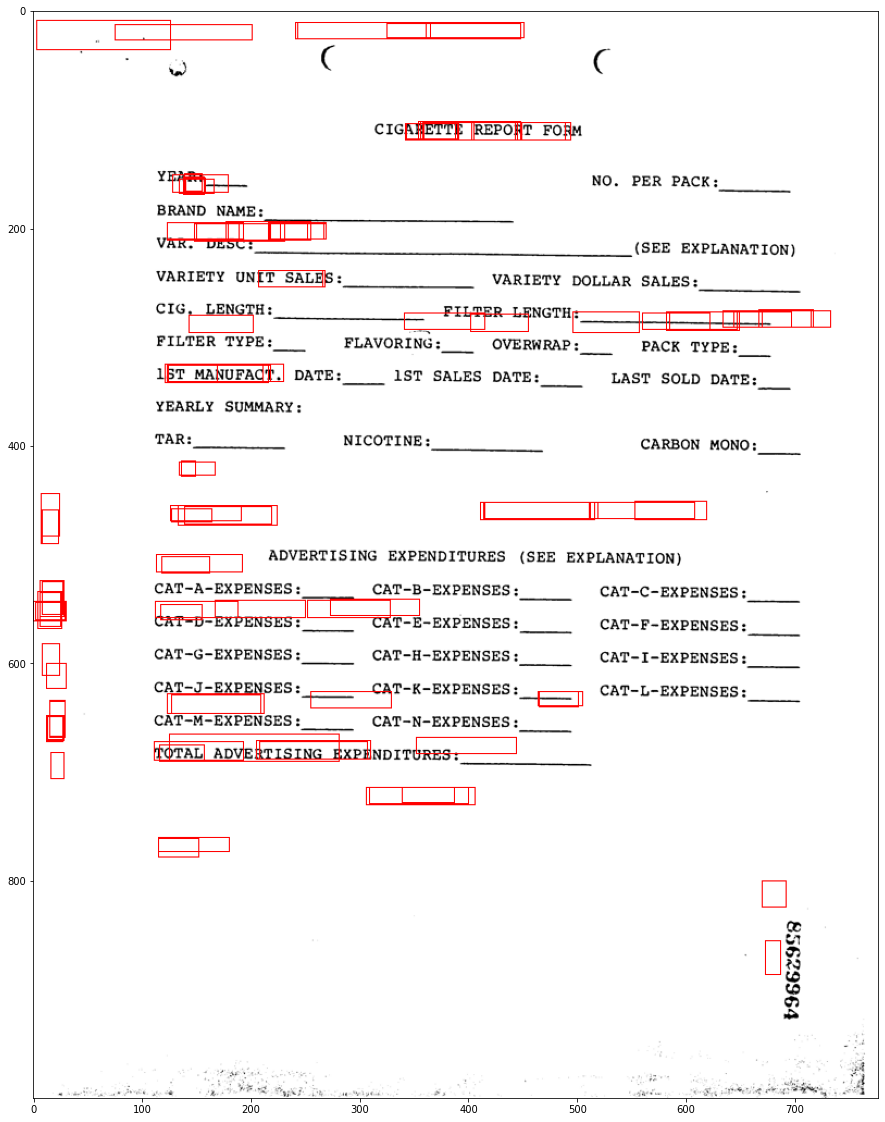

In [4]:
test_img = cv2.imread("noisy_documents_dataset/testing_data/images/85629964.png" , cv2.IMREAD_COLOR)
label_list = ["question", "answer" , "header", "other"]
for box in boxes:
    cv2.rectangle(test_img , (box[0] , box[1]) , (box[2] , box[3]) , (255 , 0 , 0))


plt.figure(figsize=(20 , 20))
plt.imshow(test_img)
plt.show()
    

In [5]:
print(output[0]['labels'])

tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 3, 4, 1, 2, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 1, 1, 2, 2, 3, 4, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 3, 1, 2, 3, 1, 3, 4, 2, 2, 1, 3, 2, 1, 2,
        1, 2, 3, 1], device='cuda:0')
